# Compressible Boundary layer

## Equations

The compressible equations are given by as presented in [Hypersonic flow theory; p. 288](https://gymkhana.iitb.ac.in/~scp/scp/ocw/aerospace/AE%20624%20-%20Hypersonic%20flow%20theory/Hypersonic%20and%20high-temperature%20gas%20dynamics%20-%20John%20David%20Anderson.pdf)
:
$$
\begin{align}
 (Cf^{''})^{'} + ff^{''} &=0 \\
\left(\frac{C}{Pr}g_e^{'}\right)^{'} + fg_e^{'} + C\frac{u_\infty^2}{h_{t\infty}}\left(f^{''}\right)^2 &=0
\end{align}
$$


With the boundary conditions:
$$f(0)=0,\quad f^{'}(0)=0,\quad g_e(0)=g_{e-w}$$
Where 
$$
f^{'} = \frac{u}{u_{\infty}}, \quad g_{e} = \frac{h_t}{h_{t\infty}}, \quad h_s = h_t - \frac{1}{2}u^2
$$
and the $Pr$ and $C$ given by:
$$
Pr(h_s) = \frac{\mu(h_s) c_p(h_s)} {k(h_s)}, \quad C(h_s) =\frac{\rho(h_s) \mu(h_s)}{\rho_\infty\rho_\infty} \\
$$


## Derivation ODE
To solve the above given equations some calculus needs to be done to end up in a form that can be easily solved.

]Starting with rewriting using product rule
$$
\begin{align}
 Cf^{'''} + \left(C^{'}+ f\right)f^{''} &=0 \\
\frac{C}{Pr}g_e^{''}  + \left(\frac{C^{'}}{Pr} + C\left(\frac{1}{Pr}\right)^{'} + f \right)g_e^{'} + C\frac{u_\infty^2}{h_{t\infty}}\left(f^{''}\right)^2 &=0
\end{align}
$$
Further rewritten
$$ \frac{C}{Pr}g_e^{''}  + \left(\frac{C^{'}}{Pr} + \frac{C}{Pr^2}{Pr}^{'} + f \right)g_e^{'} + C\frac{u_\infty^2}{h_{t\infty}}\left(f^{''}\right)^2 =0 $$

Define the following variables:
$$
\begin{align}
g &= f^{'}  \\
h &= g^{'}  \\
t &= g_e^{'}
\end{align}
$$

Pluggin into original equations gives:
$$
\begin{align}
Ch^{'} + \left(C^{'}+f\right) h &= 0 \\
f' &= g \\
g' &= h \\
\frac{C}{Pr}t^{'}  + \left(\frac{C^{'}}{Pr} + \frac{C}{Pr^2}{Pr}^{'} + f \right)t + C\frac{u_{\infty}^2}{h_{t\infty}}\left(h\right)^2 &=0 \\
g_e^{'} &= t
\end{align}
$$

This gives the following ODEs to be solved

$$
\begin{align}
h^{'} &=- \frac{\left(C^{'}+f\right)}{C} h  \\
f' &= g \\
g' &= h \\
t^{'}  &=- \left(\frac{C^{'}}{C} + \frac{Pr}{Pr}^{'} + \frac{fPr}{C} \right)t - Pr\frac{u_\infty^2}{h_{t\infty}}\left(h\right)^2 \\
g_e^{'} &= t
\end{align}
$$


## Thermodynamic properties

To calculate the $Pr$ and $C$ we will use CoolProp in combination with an interpolation procedure. 

The equations for the thermodynamic properties as a function of the static enthalpy $h_s$ are given by:

$$
\begin{align}
Pr(h_s) &= \frac{\mu(h_s) c_p(h_s)} {k(h_s)} \\ 
C(h_s)  &=\frac{\rho(h_s) \mu(h_s)}{\rho_\infty\mu_\infty} \\
\end{align}
$$

The derivatives of these properties can be rewritten, given that:

$$
h_s' = h_t{'} - \frac{1}{2} \left( u^2 \right)^{'} = (h_{t\infty}g_e)^{'} - uu^{'} =h_{t\infty}g_e^{'} - u_\infty g (u_\infty g)^{'}= h_{t\infty}t - u_\infty^2 g h
$$

Which results in the following expression for the derivatives:
$$
\begin{align}
C' &= \frac{\partial C}{\partial h_s} h_s^{'} = \frac{\partial C}{\partial h_s}  \left(h_{t\infty}t - u_\infty^2 g h\right)\\
Pr' &= \frac{\partial Pr}{\partial h_s} h_s^{'} =  \frac{\partial Pr}{\partial h_s} \left(h_{t\infty}t - u_\infty^2 g h\right)
\end{align}
$$

In [3]:
from scipy.interpolate import interp1d
import  CoolProp.CoolProp as CP
class ThermodynamicTable(object):
    def __init__(self, fluid, p, hmin, hmax, ht_inf, u_inf, n):
        self.fluid = fluid
        self.P = p
        self.n  = n
        self.hmin = hmin
        self.hmax = hmax
        self._set_zeroprop(ht_inf, u_inf)
        self._create_vectors()
        self._create_functions()
    
    def set_prop(self,hs,g,h,t,u_inf,ht_inf):
        self.Pr   = self.Prf(hs)
        self.C    = self.Cf (hs)
        self.derPr= self.derPrf(hs)*(ht_inf*t-(u_inf**2)*g*h)
        self.derC = self.derCf (hs)*(ht_inf*t-(u_inf**2)*g*h)
                    
    def _set_zeroprop(self, ht_inf, u_inf):
        self.mu0 = CP.PropsSI("V", 'P', self.P, "H", ht_inf-(1/2)*(u_inf)**2, self.fluid)
        self.rho0= CP.PropsSI("D", 'P', self.P, "H", ht_inf-(1/2)*(u_inf)**2, self.fluid)

    def _create_vectors(self):
        self.Hvec    = np.array([self.hmin+(self.hmax-self.hmin)*i/(self.n-1) for i in range(0,self.n)])
        self.Prvec   = np.array([self._calc_Pr(h) for h in self.Hvec])
        self.Cvec    = np.array([self._calc_C (h) for h in self.Hvec])
        self.derPrvec= np.array([self._calc_derivative(self._calc_Pr,h) for h in self.Hvec])
        self.derCvec = np.array([self._calc_derivative(self._calc_C ,h) for h in self.Hvec])
 
    def _create_functions(self):
        self.Prf   = interp1d(self.Hvec, self.Prvec   ,kind='cubic')
        self.Cf    = interp1d(self.Hvec, self.Cvec    ,kind='cubic')
        self.derPrf= interp1d(self.Hvec, self.derPrvec,kind='cubic')
        self.derCf = interp1d(self.Hvec, self.derCvec ,kind='cubic')
    
    def _calc_C(self,H):
        rho = CP.PropsSI("D",'P',self.P, "H", H, self.fluid)
        mu  = CP.PropsSI("V",'P',self.P, "H", H, self.fluid)
        return (rho*mu)/(self.rho0*self.mu0)
        
    def _calc_Pr(self,H):
        mu = CP.PropsSI("V",'P',self.P, "H", H, self.fluid)
        cp = CP.PropsSI("C",'P',self.P, "H", H, self.fluid)
        k  = CP.PropsSI("L",'P',self.P, "H", H, self.fluid)
        return (mu*cp)/k
               
    def _calc_derivative(self,function, h):
        delta = 1
        y2 = function(h+delta)
        y1 = function(h)
        return (y2-y1)/delta
        
    def plot(self):
        fig, ax = plt.subplots()
        ax.plot (self.Hvec/1e3, self.Prvec,   color='r', linestyle='--', label='Pr' )
        ax.plot (self.Hvec/1e3, self.Cvec,    color='r', linestyle='-' , label='C'  )
        ax.set_xlabel("Enthalpy [kJ/kg]")
        ax.set_ylabel("-")
        ax.legend(loc=4)
        ax1 = ax.twinx()
        ax1.plot(self.Hvec/1e3, self.derPrvec*1e3,color='b', linestyle='--', label="Pr'")
        ax1.plot(self.Hvec/1e3, self.derCvec*1e3, color='b', linestyle='-' , label="C'" )
        ax1.legend(loc=3)
        

## Initialize table

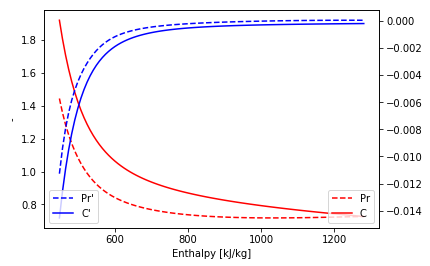

In [5]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline
fluid = "CO2"

#free stream properties
p_inf = 100e5  # [Pa]
u_inf = 10     # [m/s]
T_inf = 480    # [K]
T_wall= 520    # [K]
ht_w  = CP.PropsSI('H','T', T_wall, "P", p_inf, fluid )
ht_inf= CP.PropsSI('H','T', T_inf , "P", p_inf, fluid ) 

#initialize table
ts = ThermodynamicTable(fluid, p_inf, ht_inf*0.7,ht_inf*2,ht_inf,u_inf, 100)
ts.plot()

## Solve ODES
### Numerical Method
The odes are solved using a first order forward euler discretization. This results in:

$$
\begin{align}
h(x+\Delta x) &= h(x) -\frac{C^{'}+f(x)}{C}h(x)\Delta x& \\
f(x+\Delta x) &= f(x) +g(x)\Delta x&      \\
g(x+\Delta x) &= g(x) +h(x)\Delta x&      \\
t(x+\Delta x) &= t(x) -\left(\left(\frac{C^{'}}{C} + \frac{Pr^{'}}{Pr} + \frac{fPr}{C} \right)t(x) + Pr\frac{u_\infty^2}{h_{t\infty}}h(x)^2\right)\Delta x& \\
g_e(x+\Delta x)&= g_e(x)+t(x)\Delta x& \\
\end{align} 
$$

In [6]:
#mesh
n=10000
x = np.linspace(0,10,n); dx = np.diff(x)

#initialization
f = np.zeros(n); g = np.zeros(n); h = np.zeros(n)
ge= np.ones(n);  t = np.zeros(n); 

#bc
f[0]=0; g[0]=0; ge[0]=ht_w/ht_inf

#initial guess
h0=0.1; t0=0.1 

def solve_ode(x):
    h[0]=x[0]
    t[0]=x[1]
    for i in range(0,n-1):
        ip=i+1
        hs = ge[i]*ht_inf - (1/2)*(g[i]*u_inf)**2
        ts.set_prop(hs,g[i],h[i],t[i],u_inf,ht_inf)
        h[ip]=h[i]  -((ts.derC + f[i])/ts.C)*h[i]*dx[i]
        f[ip]=f[i] + g[i]*dx[i]
        g[ip]=g[i] + h[i]*dx[i]
        t[ip]=t[i] -((ts.derC/ts.C +ts.derPr/ts.Pr + (f[i]*ts.Pr)/ts.C)*t[i]+ts.Pr*(u_inf**2/ht_inf)*h[i]**2)*dx[i]
        ge[ip]=ge[i]+t[i]*dx[i]
    error = abs(1-g[-1])+abs(1-ge[-1])
    print(error)
    return error

res = minimize(solve_ode, np.array([h0,t0]), method='Nelder-Mead', options={'xtol': 1e-6, 'disp': True})

1.1370876201093976
1.1180117646187822
1.1592667558558636
1.0962993361506608
1.0657506428973036
1.048335989300854
1.006714909614163
0.9581294408270667
0.8848509694031838
0.8352931099535105
0.7357666241336034
0.6367816202234784
0.48969128295999853
0.44104419579852827
0.48039149103976697
0.5147215042027312
0.4819562735557017
0.4811768607663627
0.4456786643215739
0.4624960978853554
0.4208162548682223
0.5033479428460845
0.43910638385025447
0.41963754802966724
0.40910194158166036
0.39331852356985264
0.42056679363174754
0.3794473721335626
0.3593323383282412
0.3541620120804553
0.36342053400572627
0.31141166262108144
0.2738441738335937
0.25587629101937004
0.22918126014223383
0.14709257178369906
0.05941378700309263
0.009018472199674554
0.12468023439306619
0.24062321330608183
0.11539615827913252
0.1335318010826111
0.07190770969086813
0.0778209181012387
0.05058740451723798
0.03300614337634533
0.062011448729948127
0.022428714588742293
0.03178695311963797
0.02142283707928505
0.03413762134897902
0.01

## Plot solution

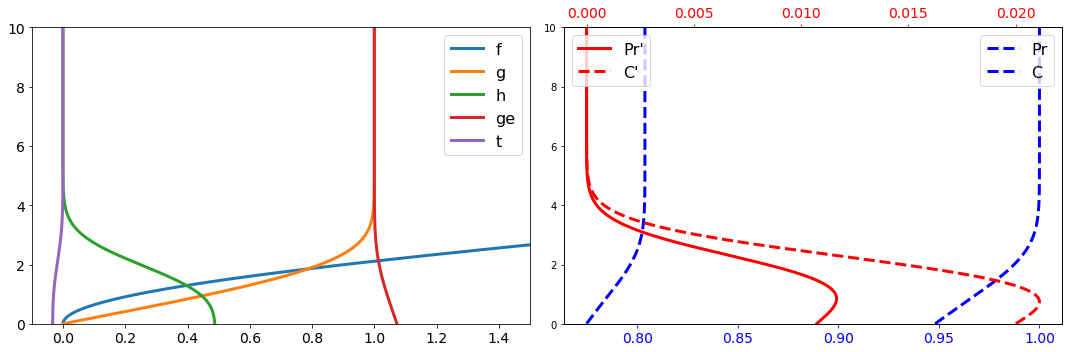

In [97]:
#calc properties
hsv = ge*ht_inf-1/2*(g*u_inf)**2
hsvp = hsv/hsv[-1]
ts.set_prop(hsv,g,h,t,u_inf,ht_inf)    

#plot
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot(f, x,label='f', linewidth=3)
ax1.plot(g, x,label='g', linewidth=3)
ax1.plot(h, x,label='h', linewidth=3)
ax1.plot(ge,x,label='ge', linewidth=3)
ax1.plot(t, x,label='t', linewidth=3)
ax1.tick_params(axis='both', labelsize=14)

ax1.set_xbound(-.1,1.5)
ax1.set_ybound(0,10)
ax1.legend(loc=1, prop={'size': 16})
ax2.plot(ts.Pr,   x, label='Pr', linestyle='--', color='b', linewidth=3)
ax2.plot(ts.C,    x, label='C', linestyle='--', color='b', linewidth=3)
ax21 = ax2.twiny()
ax21.plot(ts.derPr,x, label="Pr'", linestyle='-', color='r', linewidth=3)
ax21.plot(ts.derC, x, label="C'", linestyle='--', color='r', linewidth=3)
ax2.set_ybound(0,10)
ax21.tick_params(axis='x', colors='red',labelsize=14)
ax2.tick_params(axis='x', colors='blue',labelsize=14)
ax2.legend(loc=1, prop={'size': 16})
ax21.legend(loc=2, prop={'size': 16})
fig.tight_layout()
plt.savefig("blasius_vp.png")

## Store solution

In [65]:
import pandas as pd
df = pd.DataFrame(np.array([x,f,g,h,ge,t]).T,columns=['x','f','g','h','ge','t'])
df.to_csv("blasius_vp.csv",index=None, sep="\t", header=True)